<a href="https://colab.research.google.com/github/rexbrandy/classify_digits/blob/main/classify_digits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fashion MNIST Feed Forward Network

This is a feed forward network that is trained to identify articles of clothing. It is trained with the fashion MNIST dataset. It is a small network with 3 linear layers with ReLu activation.

### Dataloading

In [2]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor


def get_dataloaders(batch_size=64, visualize=True):
    train_dataset = datasets.FashionMNIST(
        root='data',
        train=True,
        download=True,
        transform=ToTensor()
    )

    test_dataset = datasets.FashionMNIST(
        root='data',
        train=False,
        download=True,
        transform=ToTensor()
    )

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    if visualize:
        visualize_data(train_dataset)

    return train_dataloader, test_dataloader


In [3]:
import matplotlib.pyplot as plt


def visualize_data(training_data):
    labels_map = {
        0: "T-Shirt",
        1: "Trouser",
        2: "Pullover",
        3: "Dress",
        4: "Coat",
        5: "Sandal",
        6: "Shirt",
        7: "Sneaker",
        8: "Bag",
        9: "Ankle Boot",
    }
    figure = plt.figure(figsize=(8, 8))
    cols, rows = 3, 3
    for i in range(1, cols * rows + 1):
        sample_idx = torch.randint(len(training_data), size=(1,)).item()
        img, label = training_data[sample_idx]
        figure.add_subplot(rows, cols, i)
        plt.title(labels_map[label])
        plt.axis("off")
        plt.imshow(img.squeeze(), cmap="gray")
    plt.show()



In [4]:
import torch.nn as nn

class FeedForwardNet(nn.Module):
    def __init__(self):
        super(FeedForwardNet, self).__init__()
        self.flatten = nn.Flatten()

        self.sequential = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        output = self.sequential(x)

        return output


In [5]:
def train(model, dataloader, criterion, optimizer, n_epochs=20, save_model=False, load_model=True):
    model.train()

    size = len(dataloader.dataset)
    epoch_loss = []

    best_loss = 1

    for epoch in range(1, n_epochs):
        for batch, (X, y) in enumerate(dataloader):
            # Feed forward - calculate prediction and loss
            pred = model(X)
            loss = criterion(pred, y)

            # Backpropogation - set weights and biases and zero gradients
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            epoch_loss.append(loss.item())

            if loss.item() < best_loss and save_model:
                best_loss = loss.item()

            if batch % 100 == 0:
                test_loss = loss.item()
                current = (batch + 1) * len(X)

                print(f'Epoch {epoch}  Current {current} / {size}  Loss {test_loss}')


def test(model, dataloader, criterion):
    model.eval()

    dataset_size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += criterion(pred, y).item()

            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches

    print(f'Total correct {correct} / {dataset_size} ||  Loss {test_loss}')



100%|██████████| 26421880/26421880 [00:01<00:00, 17964770.07it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 271515.14it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5010366.46it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 21065636.09it/s]


Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



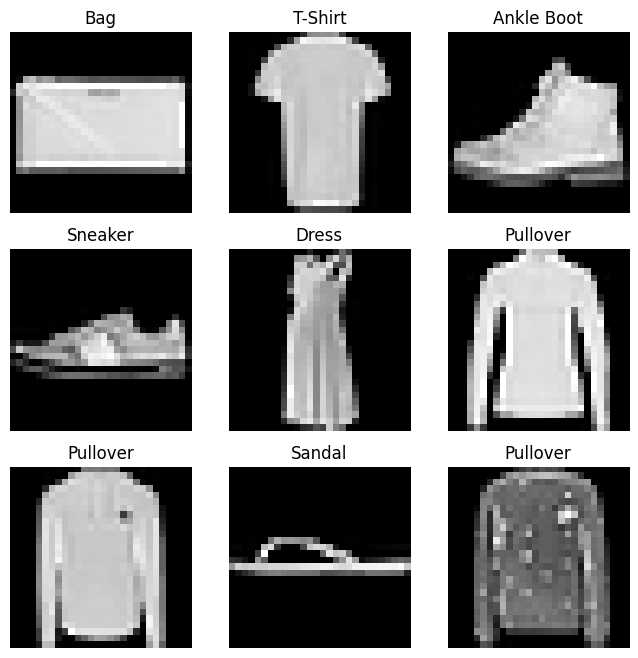

Total correct 8810.0 / 10000 ||  Loss 0.3434529698863151


"\ntotal_epochs = n_epochs + checkpoint['epoch']\n\ntorch.save({\n        'epoch': total_epochs,\n        'model_state_dict': model.state_dict(),\n        'loss_state_dict': criterion.state_dict()\n    },\n    MODEL_PATH,\n)\n"

In [6]:
MODEL_PATH = '/content/drive/MyDrive/nn/saved_models/ff_net.pth'

n_epochs = 50
lr = 0.01

# Declare model, loss, optim
model = FeedForwardNet()
criterion = nn.CrossEntropyLoss()
optim = torch.optim.SGD(model.parameters(), lr=lr)

# Load checkpoint
checkpoint = torch.load(MODEL_PATH)
model.load_state_dict(checkpoint['model_state_dict'])
criterion.load_state_dict(checkpoint['loss_state_dict'])

# Get dataloaders
training_dataloader, test_dataloader = get_dataloaders(visualize=True)

# Train
train(model, training_dataloader, criterion, optim, n_epochs)

# Test
test(model, test_dataloader, criterion)

# Save

total_epochs = n_epochs + checkpoint['epoch']

torch.save({
        'epoch': total_epochs,
        'model_state_dict': model.state_dict(),
        'loss_state_dict': criterion.state_dict()
    },
    MODEL_PATH,
)

